In [1]:
%pylab inline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


https://joshlawman.com/implementing-the-random-forest-classifier-from-sci-kit-learn/

https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

### Readying the data

In [2]:
# import dataset
iris = load_iris()
type(iris)

sklearn.utils.Bunch

In [3]:
print(iris.feature_names) # measurements to feed to random forest

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [4]:
print(iris.target_names) # different iris types (what we want to figure out for the test set)

['setosa' 'versicolor' 'virginica']


In [5]:
print(len(iris.data)) # number of samples

150


In [6]:
# split data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(iris.data,iris.target,test_size=0.2,random_state=1)

### Training the RF classifier

In [7]:
# create instance of random forest classifier
rfc = RandomForestClassifier()

In [8]:
# fit our model to the training features and labels
rfc.fit(features_train,labels_train)

RandomForestClassifier()

In [9]:
# make predictions
rfc_predictions = rfc.predict(features_test)

### Understanding the predictions

In [10]:
# 0, 1, 2 correspond to different flower classifications
print("Some initial results...\n    predicted  actual")
for i in range(10):
    print("{}.      {}         {}".format(i, rfc_predictions[i], labels_test[i]))

Some initial results...
    predicted  actual
0.      0         0
1.      1         1
2.      1         1
3.      0         0
4.      2         2
5.      1         1
6.      2         2
7.      0         0
8.      0         0
9.      2         2


In [11]:
print(features_test[0]) # model believes the first set of measurements correspond to flower type 0 (setosa iris)
print(rfc_predictions[0])

[5.8 4.  1.2 0.2]
0


In [12]:
print(labels_test[0]) # model is correct

0


In [13]:
# create a dataframe with the confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(labels_test, rfc_predictions), 
                            columns=["Predicted " + name for name in iris.target_names],
                            index = iris.target_names)

In [14]:
confusion_df

,Predicted setosa,Predicted versicolor,Predicted virginica
setosa,11,0,0
versicolor,0,12,1
virginica,0,0,6


In [15]:
print(classification_report(labels_test,rfc_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [16]:
print("Accuracy: {:0.2f}%".format(np.sum(rfc_predictions==labels_test)/len(labels_test)*100))

Accuracy: 96.67%


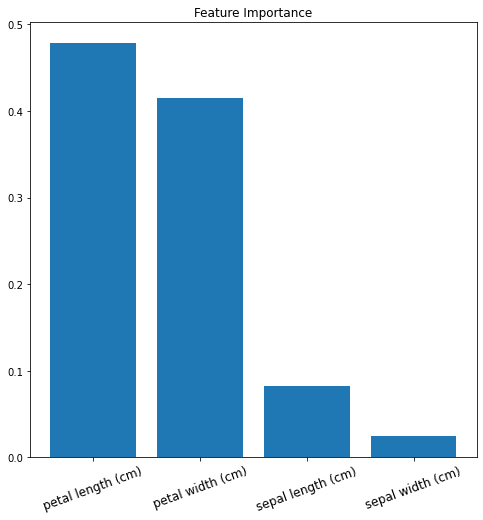

[6.93889390e-17 3.81639165e-17 1.05471187e-15 9.99200722e-16]


In [17]:
# Calculate feature importances
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1] # sort feature importances in descending order
names = [iris.feature_names[i] for i in indices] # rearrange feature names so they match the sorted feature importances

std = np.std([rfc.feature_importances_ for tree in rfc.estimators_],axis=0)

# barplot
figure(figsize=(8,8))
plt.bar(range(iris.data.shape[1]), importances[indices], yerr=std[indices])
plt.xticks(range(iris.data.shape[1]), names, rotation=20, fontsize = 12)
plt.title("Feature Importance")
plt.show()

print(std) # stds are very small so we can't see them on the barplot even though they are plotted there
           # small stds mean that the feature importances are reliable e.g. petal length really is the most important feature

In [18]:
feature_importances = pd.DataFrame(rfc.feature_importances_, index = names, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [19]:
# view the actual values for the importances
feature_importances

,importance
sepal length (cm),0.478377
sepal width (cm),0.414612
petal length (cm),0.081904
petal width (cm),0.025107


### Hyperparameter testing

In [20]:
train_acc = []
test_acc = []
num_trees = [i for i in range(1, 26, 1)]

# loop through number of trees
for num in num_trees:
    # initialize model 
    rfc = RandomForestClassifier(n_estimators=num)
    
    # train the model using the training set
    rfc.fit(features_train,labels_train)

    # get the predictions for the training set and calculate their median_diff
    rfc_predictions = rfc.predict(features_train)
    train_acc1 = np.sum(rfc_predictions==labels_train)/len(labels_train)
    train_acc.append(train_acc1)

    # get the predictions for the testing set and calculate their median_diff
    test_predictions = rfc.predict(features_test)
    test_acc1 = np.sum(test_predictions==labels_test)/len(labels_test)
    test_acc.append(test_acc1)

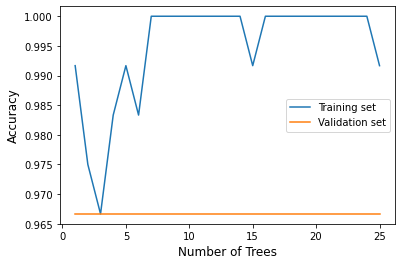

In [21]:
# what is the optimal number of trees to use for this dataset?

train_plot = plt.plot(num_trees, train_acc, label='Training set')
test_plot = plt.plot(num_trees, test_acc, label='Validation set')
plt.xlabel("Number of Trees", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.legend()

### Visualizing the random forest trees

In [22]:
from sklearn.tree import export_graphviz
import pydotplus as pydotplus
from IPython.display import Image

In [23]:
dot_data = export_graphviz(rfc.estimators_[0],
                           feature_names=iris.feature_names,
                           class_names=iris.target_names,
                           rounded=True,filled=True)

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

# save the figure of the first decision tree (rfc.estimators_[0])
graph.write_png("iris_rf0.png")

True

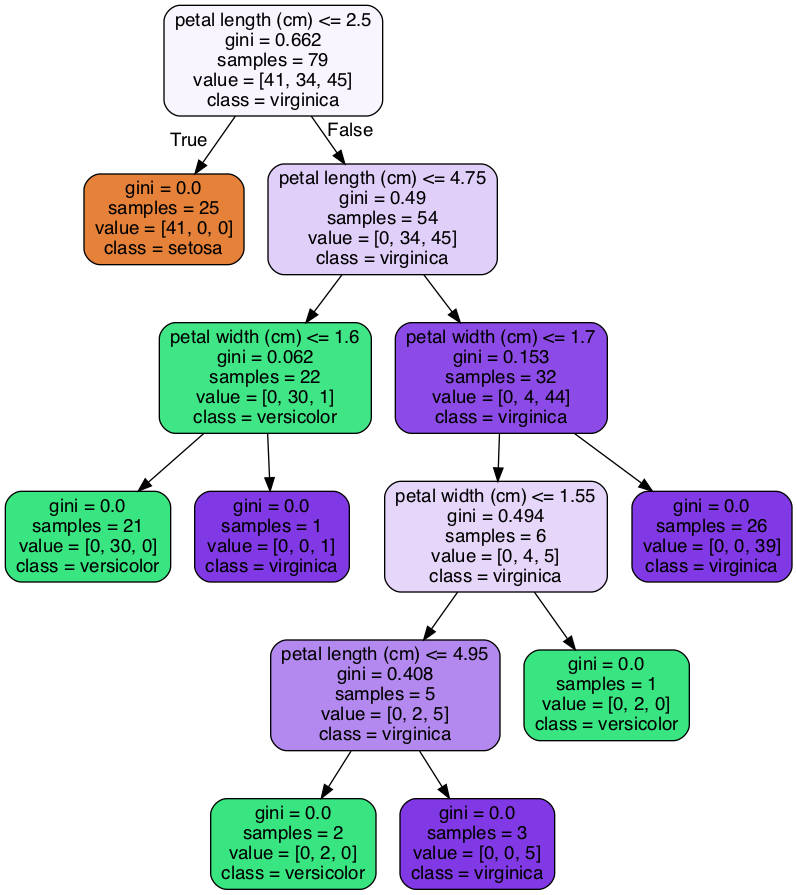

In [24]:
# View the first tree
Image(graph.create_png(), width = 500, height = 200)

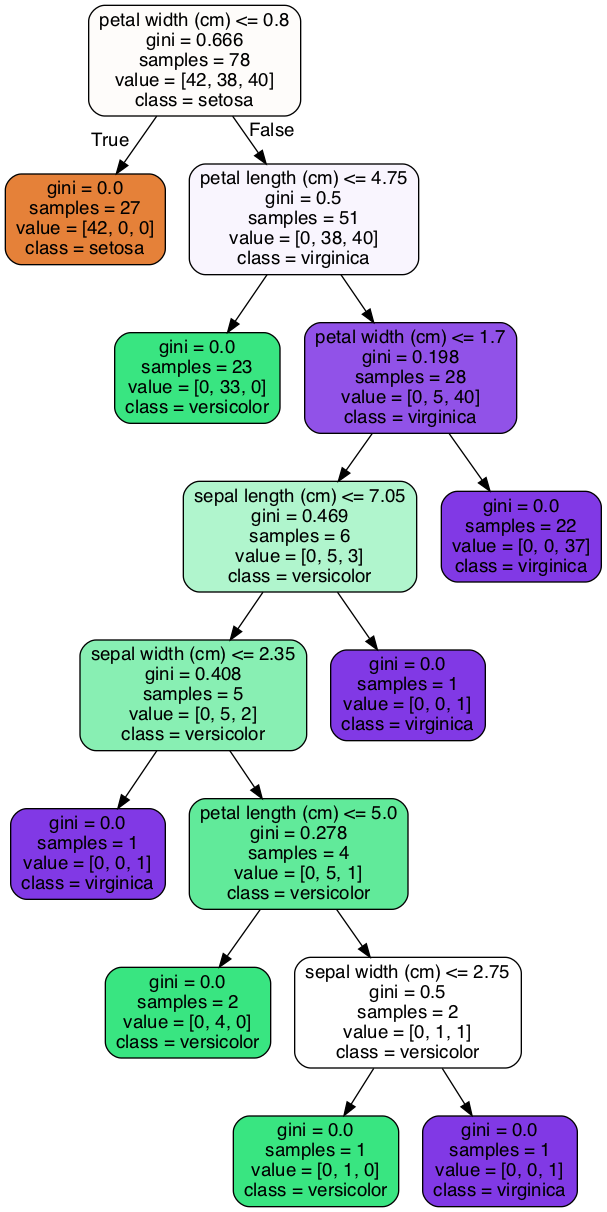

In [25]:
dot_data = export_graphviz(rfc.estimators_[1], feature_names=iris.feature_names, class_names=iris.target_names, rounded=True,filled=True)
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

# View the second tree
Image(graph.create_png(), width = 500, height = 200)
# from these two trees, looks like the setosa class is easiest to classify, while virginica and versicolor are harder to distinguish from each other